# HASSE Diagram generator -  Full run excercise with inverse direction

## 1.Importing libraries 

In [2]:
# Importing libraries
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import scipy as sci
import sys  
from itertools import combinations
from matplotlib.gridspec import GridSpec
import random
import string
import secrets


In [3]:
sys.setrecursionlimit(100000000)

## 2. Importing the dataset

In [4]:
# importing dataset
df1 = pd.read_csv(r'C:\Users\charl\OneDrive\Documents\4. Maestria IO UCV\1. Materia TDMC\HDT applied to ESG performance\hdt_esg_db_1.csv')


## 3. Preparing the dataset

In [5]:
##observando valores unicos de columna year
unique_values = df1['year'].unique()
unique_values = np.sort(unique_values)

# filtrando empresas con menos años que los años unicos de la columna year 

# Contar los años por cada ID
id_year_count = df1.groupby('ISIN')['year'].nunique()

# Filtrar los IDs que tienen todos los años
ids_with_all_years = id_year_count[id_year_count == len(unique_values)].index

# Filtrar el DataFrame original para quedarse solo con los IDs que tienen todos los años
filtered_db = df1[df1['ISIN'].isin(ids_with_all_years)]

# eliminar variables innecesarias
del unique_values, id_year_count, ids_with_all_years

In [ ]:
# contando numero de empresas resultantes
# filtered_db.describe(include='all')
# 163 empresas con todos los registros
# cada empresa tiene 20 registros

In [6]:
# 1. data imputation function
# definiendo una funcion para imputar el promedio a valores con 0 en varias columnas

def impute_missing_values(df, id_column, columns_to_impute):
    """
    Imputar valores cero con el promedio de todos los años para cada id.

    Parameters:
    df (pd.DataFrame): DataFrame que contiene los datos.
    id_column (str): Nombre de la columna que contiene los IDs.
    columns_to_impute (list): Lista de nombres de las columnas que se deben imputar.

    Returns:
    pd.DataFrame: DataFrame con los valores imputados.
    dict: Diccionario con el número de imputaciones por columna.
    """
    imputations = {}

    for col in columns_to_impute:
        imputations[col] = 0
        for id_value in df[id_column].unique():
            # Obtener el subconjunto del DataFrame para un id específico
            subset = df[df[id_column] == id_value]

            # Calcular el promedio de los valores no cero
            mean_value = subset[subset[col] != 0][col].mean()

            # Contar los ceros en la columna
            zeros_count = subset[subset[col] == 0].shape[0]

            # Imputar los valores cero con el promedio
            df.loc[(df[id_column] == id_value) & (df[col] == 0), col] = mean_value

            # Sumar el número de imputaciones para la columna
            imputations[col] += zeros_count

    return df, imputations


In [7]:
# aplicando la funcion para imputar valor promedio a registros con 0 por columna

# Llamar a la función

# 2. Generando lista de columnas a imputar
columns_to_impute = filtered_db.columns.tolist()
columnas_to_delete = ['ISIN', 'year', 'isin', 'Country', 'country', 'industry']  # 1. Columnas que deseas eliminar de la lista inicial
columns_to_impute_filtered = [columna for columna in columns_to_impute if columna not in columnas_to_delete] # 2. Lista de columnas a imputar

# 3. llamando a la funcion
df_imputed, imputations = impute_missing_values(filtered_db, 'ISIN', columns_to_impute_filtered)

# del df_imputed, del_imputations

In [8]:
# observando numero de imputaciones por columna
print("\nNúmero de imputaciones por columna:")
for col, count in imputations.items():
    print(f"{col}: {count}")

del col, count


Número de imputaciones por columna:
ENSCORE: 326
CGSCORE: 0
SOSCORE: 0
ESGcontrov: 0
Govmanagement: 0
Govshareholder: 0
GovCSRStrat: 637
CombinedESG: 0
EnEmission: 443
Eninnovation: 1344
EnResourceUse: 442
ESGscore: 0
SoCommunity: 7
SohumRigh: 1095
SoProductRes: 581
Soworkforce: 0
TBQ: 0
ROA: 0
ROA1: 0
ROA2: 0
ROA3: 0
ROIC: 0
Streturn: 0
STgowth: 1
StVol: 0
liquidity: 0
Advexp: 534
capex: 0
leverage: 88
firmsize: 0
MTB: 0
salesgrowth: 0
cash: 0
RnD: 1592
Insider: 5
GDP: 0
inflation: 170
ROE: 0
Tangibility: 0
Firmage: 0
Corruption: 0
ReguQua: 0
Polistab: 0
Law: 0
Voice: 0
Goveff: 0


In [9]:
# 2. Modificaciones al dataset 
# 2.1. normalization of the dataframe
# definiendo funcion para normalizar todas las variables

def normalize_data(df, id_column, columns_to_normalize):
    """
    Normalizar los datos usando la fórmula z = (xi - u) / desvest.

    Parameters:
    df (pd.DataFrame): DataFrame que contiene los datos.
    id_column (str): Nombre de la columna que contiene los IDs.
    columns_to_normalize (list): Lista de nombres de las columnas que se deben normalizar.

    Returns:
    pd.DataFrame: DataFrame con los valores normalizados.
    """
    # Crear un DataFrame para almacenar los datos normalizados
    df_normalized = df.copy()

    # Iterar sobre cada columna a normalizar
    for col in columns_to_normalize:
        # Calcular la media y la desviación estándar por id
        mean_values = df.groupby(id_column)[col].transform('mean')
        std_values = df.groupby(id_column)[col].transform('std')

        # Aplicar la fórmula de normalización z = (xi - u) / desvest
        df_normalized[col] = (df[col] - mean_values) / std_values

    return df_normalized

In [10]:
# 2.2 Coeficiente de variabilidad del dataset
def calculate_variability_coefficient(df, id_column, columns_to_calculate):
    """
    Calcular el coeficiente de variabilidad usando la fórmula coef = desvest / u.

    Parameters:
    df (pd.DataFrame): DataFrame que contiene los datos.
    id_column (str): Nombre de la columna que contiene los IDs.
    columns_to_calculate (list): Lista de nombres de las columnas para las cuales se debe calcular el coeficiente de variabilidad.

    Returns:
    pd.DataFrame: DataFrame con los coeficientes de variabilidad.
    """
    # Crear un DataFrame para almacenar los coeficientes de variabilidad
    df_variability_coefficient = df[[id_column]].drop_duplicates().reset_index(drop=True)

    # Iterar sobre cada columna para calcular el coeficiente de variabilidad
    for col in columns_to_calculate:
        # Calcular la media y la desviación estándar por id
        mean_values = df.groupby(id_column)[col].mean()
        std_values = df.groupby(id_column)[col].std()

        # Inicializar una serie para los coeficientes de variabilidad
        variability_coefficient = pd.Series(index=mean_values.index)

        # Calcular el coeficiente de variabilidad coef = desvest / u
        for id_value in mean_values.index:
            if mean_values[id_value] == 0:
                variability_coefficient[id_value] = 0
            else:
                variability_coefficient[id_value] = std_values[id_value] / mean_values[id_value]

        # Añadir los resultados al DataFrame de coeficientes de variabilidad
        df_variability_coefficient[col] = df_variability_coefficient[id_column].map(variability_coefficient)

    # Reemplazar NaN con 0
    df_variability_coefficient = df_variability_coefficient.fillna(0)

    return df_variability_coefficient

In [11]:
# 2.3 mediana del dataset
def calculate_median(df, id_column, columns_to_calculate):
    """
    Calcular la mediana de las columnas especificadas agrupando por id_column.

    Parameters:
    df (pd.DataFrame): DataFrame que contiene los datos.
    id_column (str): Nombre de la columna que contiene los IDs.
    columns_to_calculate (list): Lista de nombres de las columnas para las cuales se debe calcular la mediana.

    Returns:
    pd.DataFrame: DataFrame con las medianas calculadas.
    """
    # Crear un DataFrame para almacenar las medianas
    df_median = df.groupby(id_column)[columns_to_calculate].median().reset_index()

    # Reemplazar NaN con 0
    df_median = df_median.fillna(0)

    return df_median

In [12]:
#2.3 calculando la mediana de los valores
columns_to_use = columns_to_impute_filtered

df_median = calculate_median(df_imputed, "ISIN", columns_to_use)
df_median

,ISIN,ENSCORE,CGSCORE,SOSCORE,ESGcontrov,Govmanagement,Govshareholder,GovCSRStrat,CombinedESG,EnEmission,...,inflation,ROE,Tangibility,Firmage,Corruption,ReguQua,Polistab,Law,Voice,Goveff
0,AN8068571086,65.408889,50.000000,43.935001,100.000000,50.000000,50.000000,55.826333,48.534999,70.608823,...,0.264040,0.15030,0.231650,3.676221,0.390060,0.232550,-0.760394,0.166059,0.099839,0.064060
1,AT0000743059,64.030003,85.944999,83.130001,98.334999,96.430000,62.220001,82.735000,70.334999,93.115002,...,0.228713,0.13340,0.482075,3.238486,0.507553,-0.061192,1.287507,1.196491,0.439347,-0.368162
2,AU000000BHP4,83.980000,87.975002,88.725003,21.009999,98.024998,71.314999,96.854999,50.955000,91.239998,...,0.305663,0.18695,0.673217,3.676221,0.708776,0.244162,0.322891,-0.356666,0.365907,-0.006019
3,AU000000ORI1,57.810001,57.720001,54.495001,100.000000,62.090001,11.770000,75.245882,53.045000,65.682106,...,0.305663,0.14640,0.411084,3.676221,0.708776,0.244162,0.322891,-0.356666,0.365907,-0.006019
4,AU000000RIO1,80.910000,76.449997,84.170002,31.815000,91.439999,30.300000,96.854999,57.015000,85.680001,...,0.305663,0.18250,0.619674,3.676221,0.708776,0.244162,0.322891,-0.356666,0.365907,-0.006019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,US91913Y1001,47.140001,80.059998,37.160000,81.979999,85.319999,65.885000,64.916785,51.030001,44.015000,...,0.264040,0.12915,0.570645,3.511434,0.390060,0.232550,-0.760394,0.166059,0.099839,0.064060
166,US92343V1044,63.212940,70.130001,70.689999,18.700000,62.055000,79.794998,76.720625,42.759998,64.490002,...,0.264040,0.20600,0.390050,3.384247,0.390060,0.232550,-0.760394,0.166059,0.099839,0.064060
167,US9291601097,46.980588,39.750000,39.000000,100.000000,35.470000,58.820000,28.124706,39.105002,44.694375,...,0.264040,0.10085,0.425092,3.676221,0.390060,0.232550,-0.760394,0.166059,0.099839,0.064060
168,US9311421039,80.755001,75.860000,78.305001,5.000000,78.115002,59.049999,71.404999,40.210001,71.605000,...,0.264040,0.20695,0.574026,3.676221,0.390060,0.232550,-0.760394,0.166059,0.099839,0.064060


In [13]:
# 2.4. normalizando df_imputed
df_normalized = normalize_data(df_imputed, 'ISIN', columns_to_use)

#este es para un ejercicio posterior

In [14]:
# 2.5 calculando coeficiente de variabilidad

df_variability = calculate_variability_coefficient(df_imputed,'ISIN',columns_to_use)

df_variability

,ISIN,ENSCORE,CGSCORE,SOSCORE,ESGcontrov,Govmanagement,Govshareholder,GovCSRStrat,CombinedESG,EnEmission,...,inflation,ROE,Tangibility,Firmage,Corruption,ReguQua,Polistab,Law,Voice,Goveff
0,AN8068571086,0.233685,0.290641,0.334236,0.298066,0.296197,0.167236,0.240831,0.333447,0.197731,...,0.527204,2.987350,0.190862,0.041487,0.503676,2.254826,-0.835935,1.927979,3.453716,4.242871
1,AT0000743059,0.234675,0.070107,0.049152,0.380578,0.106413,0.253807,0.083839,0.137300,0.059906,...,0.584020,0.726446,0.114072,0.075014,0.259821,-2.007778,0.437813,0.450068,0.449428,-2.149998
2,AU000000BHP4,0.076786,0.255574,0.155134,0.902567,0.375966,0.422511,0.090396,0.151300,0.047761,...,0.538113,0.709055,0.132773,0.041487,0.105497,1.483689,0.894508,-1.617762,0.296415,-28.492906
3,AU000000ORI1,0.190760,0.253661,0.327325,0.264129,0.301572,1.058152,0.225559,0.176665,0.169783,...,0.538113,1.218147,0.153360,0.041487,0.105497,1.483689,0.894508,-1.617762,0.296415,-28.492906
4,AU000000RIO1,0.041723,0.171799,0.088224,0.738234,0.259503,0.665335,0.084294,0.222833,0.047448,...,0.538113,0.688823,0.121779,0.041487,0.105497,1.483689,0.894508,-1.617762,0.296415,-28.492906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,US91913Y1001,0.374560,0.129116,0.350016,0.470891,0.123310,0.197095,0.208907,0.254500,0.241860,...,0.527204,1.019898,0.074235,0.051600,0.503676,2.254826,-0.835935,1.927979,3.453716,4.242871
166,US92343V1044,0.200839,0.299035,0.302462,0.843338,0.352960,0.216264,0.162274,0.311797,0.322060,...,0.527204,0.696998,0.105282,0.061284,0.503676,2.254826,-0.835935,1.927979,3.453716,4.242871
167,US9291601097,0.495174,0.427850,0.355464,0.354842,0.595379,0.378783,0.559641,0.412870,0.365524,...,0.527204,0.880758,0.122091,0.041487,0.503676,2.254826,-0.835935,1.927979,3.453716,4.242871
168,US9311421039,0.176255,0.335248,0.287542,1.609265,0.363219,0.377361,0.104499,0.233387,0.263527,...,0.527204,0.184747,0.182567,0.041487,0.503676,2.254826,-0.835935,1.927979,3.453716,4.242871


In [15]:
#2.6 calculando ultimo valor puntual
df_punctual = df_imputed[df_imputed["year"] == 2021]
df_punctual = df_punctual.fillna(0)

In [16]:
def generate_random_label(base_label):
    random_letter = random.choice(string.ascii_letters)  # Elige una letra aleatoria (mayúscula o minúscula)
    return base_label + random_letter

In [17]:
# 3. generating labels / en los tres dataset de este ejemplo
df_punctual['Labels'] = df_punctual['ISIN'].str[:2] + df_punctual['ISIN'].str[-2:] 
df_punctual['Labels'] = df_punctual['Labels'].apply(generate_random_label)

df_median['Labels'] = df_median['ISIN'].str[:2] + df_median['ISIN'].str[-2:] 
df_median['Labels'] = df_median['Labels'].apply(generate_random_label)

df_variability['Labels'] = df_variability['ISIN'].str[:2] + df_variability['ISIN'].str[-2:] 
df_variability['Labels'] = df_variability['Labels'].apply(generate_random_label)


In [ ]:
# 6. observando datasets
#df_imputed
#df_normalized
#df_punctual > este tiene 5 variables mas que son no numericas
#df_median
#df_variability

## 4. Hasse Diagram of the resulting dataset

In [20]:
# 1.1 defining function to construct the hasse matrix (direct direction)

def hasse_matrix_direct(df, criteria_columns):
    n = len(df)
    H = np.zeros((n, n), dtype=int)
    
    for i in range(n):
        for j in range(n):
            if i != j:
                comparisons = [df.iloc[i][col] <= df.iloc[j][col] for col in criteria_columns]
                strict_comparisons = [df.iloc[i][col] < df.iloc[j][col] for col in criteria_columns]
                
                if all(strict_comparisons):
                    H[i, j] = -1
                elif all(comparisons):
                    H[i, j] = 1
                else:
                    H[i, j] = 0

    return H

In [21]:
# 1.2 defining function to construct the hasse matrix (inverse direction)

def hasse_matrix_inverse(df, criteria_columns):
    n = len(df)
    H = np.zeros((n, n), dtype=int)
    
    for i in range(n):
        for j in range(n):
            if i != j:
                comparisons = [df.iloc[i][col] >= df.iloc[j][col] for col in criteria_columns]
                strict_comparisons = [df.iloc[i][col] > df.iloc[j][col] for col in criteria_columns]
                
                if all(strict_comparisons):
                    H[i, j] = -1
                elif all(comparisons):
                    H[i, j] = 1
                else:
                    H[i, j] = 0

    return H

In [22]:
# 2. defining criteria columns
selected_columns = ["ROA","ROE","EnEmission","Soworkforce", "Govmanagement"]

In [23]:
# 3. Obtaining hasse matrix
#df_punctual > este tiene 5 variables mas que son no numericas
#df_median
#df_variability


H_1 = hasse_matrix_direct(df_punctual, selected_columns) # puntual
H_2 = hasse_matrix_direct(df_median, selected_columns) # mediana
H_3 = hasse_matrix_inverse(df_variability, selected_columns) # variabilidad
#print("Matriz Hasse:\n", H_1)

In [24]:
# 3. Construimos el grafo a partir de la matrix Hasse / una networkx
def build_graph(H, df, P):
    G = nx.DiGraph()

    n = len(H)

    # Agregar todos los nodos al grafo antes de agregar los arcos
    for i in range(n):
        G.add_node(df.iloc[i][P])

    for i in range(n):
        for j in range(n):
            if H[i, j] == 1 or H[i, j] == -1:
                G.add_edge(df.iloc[i][P], df.iloc[j][P])

    print(f"Número total de nodos esperados: {n}")
    print(f"Número total de nodos en el grafo: {len(G.nodes)}")
    print(f"Número total de arcos en el grafo: {len(G.edges)}")
    
    return G


In [25]:
# 4. Construir el grafo
G_graph_arcs_1_puntual = build_graph(H_1,df_punctual, 'ISIN')
G_graph_arcs_2_mediana = build_graph(H_2,df_median, 'ISIN')
G_graph_arcs_3_variabilidad = build_graph(H_3,df_variability, 'ISIN')

#print("Arcos del grafo:\n", G_graph_arcs.edges())

Número total de nodos esperados: 170
Número total de nodos en el grafo: 170
Número total de arcos en el grafo: 2104
Número total de nodos esperados: 170
Número total de nodos en el grafo: 170
Número total de arcos en el grafo: 2481
Número total de nodos esperados: 170
Número total de nodos en el grafo: 170
Número total de arcos en el grafo: 2249


In [26]:
# 5. Funcion para eliminar transitividad del grafo / usa networkx
def remove_transitive_edges(x):
    transitive_edges = set()
    
    for node in x:
        successors = set(x.successors(node))
        for successor in successors:
            successors_of_successor = set(x.successors(successor))
            transitive_edges.update((node, trans_successor) for trans_successor in successors_of_successor if trans_successor in successors)
    
    x.remove_edges_from(transitive_edges)
    return x


In [27]:
# 6. Eliminar las relaciones con  transitividad
G_graph_arcs_reduced_1_puntual = remove_transitive_edges(G_graph_arcs_1_puntual)
G_graph_arcs_reduced_2_mediana = remove_transitive_edges(G_graph_arcs_2_mediana)
G_graph_arcs_reduced_3_variabilidad = remove_transitive_edges(G_graph_arcs_3_variabilidad)


In [28]:
# 7. Funcion para identificar nodos maximos y minimos
def find_max_min(x):
    maxima = [node for node in x.nodes() if x.out_degree(node) == 0]
    minima = [node for node in x.nodes() if x.in_degree(node) == 0]

    return maxima, minima

In [29]:
# 8. Encontrar máximos y mínimos en el poset
maxima_1, minima_1 = find_max_min(G_graph_arcs_reduced_1_puntual)
maxima_2, minima_2 = find_max_min(G_graph_arcs_reduced_2_mediana)
maxima_3, minima_3 = find_max_min(G_graph_arcs_reduced_3_variabilidad)

In [30]:
# 9. Función para asignar niveles de jerarquía a los nodos
def assign_hierarchy_levels(x):
    levels = {node: 0 for node in x.nodes()}
    
    # Asignar nivel 0 a los nodos con in-degree 0 (máximos)
    for node in x.nodes():
        if x.in_degree(node) == 0:
            levels[node] = 0
    
    # Actualizar niveles para otros nodos
    def update_levels(node, level):
        for successor in x.successors(node):
            levels[successor] = max(levels[successor], level + 1)
            update_levels(successor, levels[successor])
    
    for node in x.nodes():
        if x.in_degree(node) == 0:
            update_levels(node, 0)
    
    # Invertir los niveles para que los máximos estén en la parte superior
    max_level = max(levels.values())
    for node in levels:
        levels[node] = max_level - levels[node]
    
    return levels

In [31]:
# 10. Asignar niveles de jerarquía
levels_1 = assign_hierarchy_levels(G_graph_arcs_reduced_1_puntual)
levels_2 = assign_hierarchy_levels(G_graph_arcs_reduced_2_mediana)
levels_3 = assign_hierarchy_levels(G_graph_arcs_reduced_3_variabilidad)

In [32]:
# 11. Funcion para crear posiciones para los nodos
def create_positions(hierarchy_levels):
    pos = {}
    level_to_nodes = {}
    
    for node, level in hierarchy_levels.items():
        if level not in level_to_nodes:
            level_to_nodes[level] = []
        level_to_nodes[level].append(node)
    
    max_width = max(len(nodes) for nodes in level_to_nodes.values())
    
    for level, nodes in level_to_nodes.items():
        x_spacing = max_width / (len(nodes) + 1)
        for i, node in enumerate(nodes):
            pos[node] = ((i + 1) * x_spacing, -level)  # Nota que la jerarquía más baja está abajo
    
    return pos

In [33]:
# 12. Creando posiciones para el grafo
pos_1_puntual = create_positions(levels_1)
pos_2_mediana = create_positions(levels_2)
pos_3_variabilidad = create_positions(levels_3)


In [34]:
# valores de puntual
G_graph_arcs_reduced_relabeled_1_puntual = nx.relabel_nodes(
    G_graph_arcs_reduced_1_puntual,
    (lambda nodes: lambda x: x[-1:] + f"{nodes.index(x)+1:03}")(list(pos_1_puntual))
)

# valores mediana
G_graph_arcs_reduced_relabeled_2_mediana = nx.relabel_nodes(
    G_graph_arcs_reduced_2_mediana,
    (lambda nodes: lambda x: x[-1:] + f"{nodes.index(x)+1:03}")(list(pos_2_mediana))
)

# valores variabilidad
G_graph_arcs_reduced_relabeled_3_variabilidad = nx.relabel_nodes(
    G_graph_arcs_reduced_3_variabilidad,
    (lambda nodes: lambda x: x[-1:] + f"{nodes.index(x)+1:03}")(list(pos_3_variabilidad))
)

# G_graph_arcs_reduced_relabeled = nx.relabel_nodes(
#    G_graph_arcs_reduced,
#    (lambda nodes: lambda x: x[-1:] + f"{nodes.index(x)+1:03}")(list(pos))
#)

In [35]:
#calculando pos_2 para cada dataset

# puntual
key_transform_1 = (lambda nodes: lambda x: x[-1:] +  f"{nodes.index(x)+1:03}")(list(pos_1_puntual))
pos_1_puntual_pos_2 = {key_transform_1(key): value for key, value in pos_1_puntual.items()}

# mediana
key_transform_2 = (lambda nodes: lambda x: x[-1:] +  f"{nodes.index(x)+1:03}")(list(pos_2_mediana))
pos_2_mediana_pos_2 = {key_transform_2(key): value for key, value in pos_2_mediana.items()}


# variabilidad
key_transform_3 = (lambda nodes: lambda x: x[-1:] +  f"{nodes.index(x)+1:03}")(list(pos_3_variabilidad))
pos_3_variabilidad_pos_2 = {key_transform_3(key): value for key, value in pos_3_variabilidad.items()}

In [ ]:
# 13. Visualizando el grafo del dataset puntual

#levels_1 = assign_hierarchy_levels(G_graph_arcs_reduced_1_puntual)
#levels_2 = assign_hierarchy_levels(G_graph_arcs_reduced_2_mediana)
#levels_3 = assign_hierarchy_levels(G_graph_arcs_reduced_3_variabilidad)


#plt.figure(figsize=(10, 8))
#nx.draw(G_graph_arcs_reduced_relabeled_1_puntual
#        , pos_1_puntual_pos_2, with_labels=True
#        , node_color='lightblue'
#        , node_size=300, font_size=10
#        , font_color='black'
#        , font_weight='bold'
#        , edge_color='gray'
#        , width=1, alpha=0.7)
#plt.title("Diagrama de Hasse")
#plt.show()

# 5. Generating Hasse Diagram reports (graph, final table)

In [36]:
# Paso 1: Crear un DataFrame con los labels originales y los labels minimizados

# para grafo puntual
label_original_1_puntual = list(pos_1_puntual.keys())
label_minimized_1_puntual = list(pos_1_puntual_pos_2.keys())
df_labels_1_puntual = pd.DataFrame({'label': label_original_1_puntual, 'label_relabeled': label_minimized_1_puntual})

# para grafo mediana
label_original_2_mediana = list(pos_2_mediana.keys())
label_minimized_2_mediana = list(pos_2_mediana_pos_2.keys())
df_labels_2_mediana = pd.DataFrame({'label': label_original_2_mediana, 'label_relabeled': label_minimized_2_mediana})

# para grafo variabilidad
label_original_3_variabilidad = list(pos_3_variabilidad.keys())
label_minimized_3_variabilidad = list(pos_3_variabilidad_pos_2.keys())
df_labels_3_variabilidad = pd.DataFrame({'label': label_original_3_variabilidad, 'label_relabeled': label_minimized_3_variabilidad})

In [37]:
# Paso intermedio: Calculamos sucesores, predecesores e incomparables desde la matriz hasse
#G_graph_arcs = build_graph(H,df_prueba, 'ISIN')

# Etiquetas de las filas/columnas
labels_1 = df_punctual['ISIN'].tolist()
labels_2 = df_median['ISIN'].tolist()
labels_3 = df_variability['ISIN'].tolist() 

In [38]:
# Crear un DataFrame para cada matriz Hasse
df_hasse_1 = pd.DataFrame(H_1, index=labels_1, columns=labels_1)
df_hasse_2 = pd.DataFrame(H_2, index=labels_2, columns=labels_2)
df_hasse_3 = pd.DataFrame(H_3, index=labels_3, columns=labels_3)

In [39]:
# funcion para el calculo de LOPM
# Definir el total de nodos

def calculo_lopm(labels, H):
    '''
    Calcula el indicador LOPM para cada label definida
    Parametros
    Label: ID de cada nodo
    H: Matriz hasse correspondiente al dataset
    '''


    n = len(labels)

    # Inicializar listas para los resultados
    num_successors_list = []
    num_predecessors_list = []
    num_incomparable_list = []
    LOPM_list = []

    # Calcular sucesores, inferiores, superiores e incomparables
    for label in labels:
        idx = labels.index(label)  # Obtener el índice correcto de la etiqueta
        num_successors = np.sum(np.abs(H[:, idx]))
        num_predecessors = num_successors + 1
        num_superiors = np.sum(np.abs(H[idx, :])) + 1
        num_incomparable = n - num_successors - num_superiors
        LOPM = (abs(num_successors) + 1) * (n + 1) / (n + 1 - abs(num_incomparable))
        
        num_successors_list.append(num_successors)
        num_predecessors_list.append(num_predecessors)
        num_incomparable_list.append(num_incomparable)
        LOPM_list.append(LOPM)

    # Crear un DataFrame con los resultados
    df_results_puntual_1 = pd.DataFrame({
        'label': labels,
        'num_successors': num_successors_list,
        'num_predecessors': num_predecessors_list,
        'num_incomparable': num_incomparable_list,
        'LOPM': LOPM_list
    })

    return df_results_puntual_1

#print(df_results_puntual_1)


In [40]:
# caculando los lopm para cada dataset

# puntual
df_results_puntual_1 = calculo_lopm(labels_1, H_1)

# mediana
df_results_mediana_2 = calculo_lopm(labels_2, H_2)

# variabilidad
df_results_variabilidad_3 = calculo_lopm(labels_3, H_3)

In [41]:
# Paso 2: Calcular las características adicionales para cada nodo en G_graph_arcs_reduced
def calculate_node_features(G, node,levels):
    num_successors = len(list(G.successors(node)))
    num_predecessors = len(list(G.predecessors(node)))
    
    all_nodes = set(G.nodes())
    comparable_nodes = set(nx.ancestors(G, node)) | set(nx.descendants(G, node)) | {node}
    num_incomparable = len(all_nodes - comparable_nodes)
    
    local_max = 1 if num_successors == 0 else 0
    global_max = 1 if local_max and node == max(nx.topological_sort(G), key=lambda x: len(nx.descendants(G, x))) else 0
    
    local_min = 1 if num_predecessors == 0 else 0
    global_min = 1 if local_min and node == min(nx.topological_sort(G), key=lambda x: len(nx.ancestors(G, x))) else 0
    
    # Obtener el nivel de jerarquía desde el diccionario levels
    max_level = max(levels.values())
    hierarchy_level = max_level - levels[node]
        
    return {
        'local_max': local_max,
        'global_max': global_max,
        'local_min': local_min,
        'global_min': global_min,
        'hierarchy_level': hierarchy_level
    }

In [42]:
# Aplicar la función a cada nodo y construir un DataFrame con los resultados

# puntual
features_1 = [calculate_node_features(G_graph_arcs_reduced_1_puntual, node,levels_1) for node in label_original_1_puntual]
df_features_1 = pd.DataFrame(features_1, index=label_original_1_puntual).reset_index()
df_features_1.rename(columns={'index': 'label'}, inplace=True)

# mediana
features_2 = [calculate_node_features(G_graph_arcs_reduced_2_mediana, node,levels_2) for node in label_original_2_mediana]
df_features_2 = pd.DataFrame(features_2, index=label_original_2_mediana).reset_index()
df_features_2.rename(columns={'index': 'label'}, inplace=True)

# variabilidad
features_3 = [calculate_node_features(G_graph_arcs_reduced_3_variabilidad, node,levels_3) for node in label_original_3_variabilidad]
df_features_3 = pd.DataFrame(features_3, index=label_original_3_variabilidad).reset_index()
df_features_3.rename(columns={'index': 'label'}, inplace=True)

In [43]:
# Paso 3: Combinar los DataFrames de labels y características

#puntual
df_combined_v1_1_puntual = pd.merge(df_labels_1_puntual, df_features_1, on='label')
df_combined_v1_1_puntual = pd.merge(df_combined_v1_1_puntual, df_results_puntual_1, on = 'label')
#df_combined_v1_1_puntual

#mediana
df_combined_v1_2_mediana = pd.merge(df_labels_2_mediana, df_features_2, on='label')
df_combined_v1_2_mediana = pd.merge(df_combined_v1_2_mediana, df_results_mediana_2, on = 'label')
#df_combined_v1_2_mediana

#variabilidad
df_combined_v1_3_variabilidad = pd.merge(df_labels_3_variabilidad, df_features_3, on='label')
df_combined_v1_3_variabilidad = pd.merge(df_combined_v1_3_variabilidad, df_results_variabilidad_3, on = 'label')
#df_combined_v1_3_variabilidad


In [ ]:
# Paso 4: describe del df_combined_v1

#df_combined_v1.describe(include = "all")

In [ ]:
#df_combined_v1.to_csv('prueba_9.csv')

In [44]:
# Paso 5: haciendo segundo reporte para puntuales


# 1. Nodos totales
total_nodes = len(df_combined_v1_1_puntual)

# 2. Nodos Maximos locales
local_max_nodes = df_combined_v1_1_puntual['local_max'].sum()

# 3. Nodos Minimos locales
local_min_nodes = df_combined_v1_1_puntual['local_min'].sum()

# 4. N° Jerarquias
total_hierarchies = df_combined_v1_1_puntual['hierarchy_level'].nunique()

# 5. N° Nodos en cada jerarquia
nodes_per_hierarchy = df_combined_v1_1_puntual['hierarchy_level'].value_counts().sort_index().to_dict()

# 6. N° Vertices (Edges)
total_edges = G_graph_arcs_reduced_1_puntual.number_of_edges()


# 7. N° Cadenas
def count_chains(G, df):
    chains = 0
    max_hierarchy_level = df['hierarchy_level'].max()
    initial_nodes = df[df['hierarchy_level'] == 0]['label']
    for node in initial_nodes:
        for level in range(1, max_hierarchy_level + 1):
            targets = df[df['hierarchy_level'] == level]['label']
            for target in targets:
                chains += sum(1 for _ in nx.all_simple_paths(G, source=node, target=target))
    return chains

total_chains = count_chains(G_graph_arcs_reduced_1_puntual, df_combined_v1_1_puntual)

# 8. Número de Anticadenas (Aproximación)
def count_anticadenas_approx(G, sample_size):
    nodes = list(G.nodes())
    anticadenas = 0
    sampled_combinations = combinations(nodes, 2)
    for subset in sampled_combinations:
        if not nx.has_path(G, subset[0], subset[1]) and not nx.has_path(G, subset[1], subset[0]):
            anticadenas += 1
            if anticadenas >= sample_size:
                break
    return anticadenas

total_anticadenas = count_anticadenas_approx(G_graph_arcs_reduced_1_puntual, 100000)

# Crear el reporte en un DataFrame
reporte_1 = pd.DataFrame({
    'Total Nodes': [total_nodes],
    'Local Max Nodes': [local_max_nodes],
    'Local Min Nodes': [local_min_nodes],
    'Total Hierarchies': [total_hierarchies],
    'Nodes Per Hierarchy': [nodes_per_hierarchy],
    'Total Edges': [total_edges],
    'Total Chains': [total_chains],
    'Total Antichains': [total_anticadenas]
})

# Mostrar el reporte
print(reporte_1)

   Total Nodes  Local Max Nodes  Local Min Nodes  Total Hierarchies  \
0          170               32               26                  7   

                               Nodes Per Hierarchy  Total Edges  Total Chains  \
0  {0: 26, 1: 51, 2: 44, 3: 25, 4: 17, 5: 5, 6: 2}         1119          4094   

   Total Antichains  
0             12261  


In [45]:
# Paso 6: haciendo segundo reporte para mediana

# 1. Nodos totales
total_nodes = len(df_combined_v1_2_mediana)

# 2. Nodos Maximos locales
local_max_nodes = df_combined_v1_2_mediana['local_max'].sum()

# 3. Nodos Minimos locales
local_min_nodes = df_combined_v1_2_mediana['local_min'].sum()

# 4. N° Jerarquias
total_hierarchies = df_combined_v1_2_mediana['hierarchy_level'].nunique()

# 5. N° Nodos en cada jerarquia
nodes_per_hierarchy = df_combined_v1_2_mediana['hierarchy_level'].value_counts().sort_index().to_dict()

# 6. N° Vertices (Edges)
total_edges = G_graph_arcs_reduced_2_mediana.number_of_edges()


# 7. N° Cadenas
def count_chains(G, df):
    chains = 0
    max_hierarchy_level = df['hierarchy_level'].max()
    initial_nodes = df[df['hierarchy_level'] == 0]['label']
    for node in initial_nodes:
        for level in range(1, max_hierarchy_level + 1):
            targets = df[df['hierarchy_level'] == level]['label']
            for target in targets:
                chains += sum(1 for _ in nx.all_simple_paths(G, source=node, target=target))
    return chains

total_chains = count_chains(G_graph_arcs_reduced_2_mediana, df_combined_v1_2_mediana)

# 8. Número de Anticadenas (Aproximación)
def count_anticadenas_approx(G, sample_size):
    nodes = list(G.nodes())
    anticadenas = 0
    sampled_combinations = combinations(nodes, 2)
    for subset in sampled_combinations:
        if not nx.has_path(G, subset[0], subset[1]) and not nx.has_path(G, subset[1], subset[0]):
            anticadenas += 1
            if anticadenas >= sample_size:
                break
    return anticadenas

total_anticadenas = count_anticadenas_approx(G_graph_arcs_reduced_2_mediana, 100000)

# Crear el reporte en un DataFrame
reporte_2 = pd.DataFrame({
    'Total Nodes': [total_nodes],
    'Local Max Nodes': [local_max_nodes],
    'Local Min Nodes': [local_min_nodes],
    'Total Hierarchies': [total_hierarchies],
    'Nodes Per Hierarchy': [nodes_per_hierarchy],
    'Total Edges': [total_edges],
    'Total Chains': [total_chains],
    'Total Antichains': [total_anticadenas]
})

# Mostrar el reporte
print(reporte_2)

   Total Nodes  Local Max Nodes  Local Min Nodes  Total Hierarchies  \
0          170               25               34                  7   

                               Nodes Per Hierarchy  Total Edges  Total Chains  \
0  {0: 34, 1: 45, 2: 44, 3: 26, 4: 13, 5: 7, 6: 1}         1238          6712   

   Total Antichains  
0             11884  


In [46]:
# Paso 7: haciendo segundo reporte para coef de variabilidad

# 1. Nodos totales
total_nodes = len(df_combined_v1_3_variabilidad)

# 2. Nodos Maximos locales
local_max_nodes = df_combined_v1_3_variabilidad['local_max'].sum()

# 3. Nodos Minimos locales
local_min_nodes = df_combined_v1_3_variabilidad['local_min'].sum()

# 4. N° Jerarquias
total_hierarchies = df_combined_v1_3_variabilidad['hierarchy_level'].nunique()

# 5. N° Nodos en cada jerarquia
nodes_per_hierarchy = df_combined_v1_3_variabilidad['hierarchy_level'].value_counts().sort_index().to_dict()

# 6. N° Vertices (Edges)
total_edges = G_graph_arcs_reduced_3_variabilidad.number_of_edges()


# 7. N° Cadenas
def count_chains(G, df):
    chains = 0
    max_hierarchy_level = df['hierarchy_level'].max()
    initial_nodes = df[df['hierarchy_level'] == 0]['label']
    for node in initial_nodes:
        for level in range(1, max_hierarchy_level + 1):
            targets = df[df['hierarchy_level'] == level]['label']
            for target in targets:
                chains += sum(1 for _ in nx.all_simple_paths(G, source=node, target=target))
    return chains

total_chains = count_chains(G_graph_arcs_reduced_3_variabilidad, df_combined_v1_3_variabilidad)

# 8. Número de Anticadenas (Aproximación)
def count_anticadenas_approx(G, sample_size):
    nodes = list(G.nodes())
    anticadenas = 0
    sampled_combinations = combinations(nodes, 2)
    for subset in sampled_combinations:
        if not nx.has_path(G, subset[0], subset[1]) and not nx.has_path(G, subset[1], subset[0]):
            anticadenas += 1
            if anticadenas >= sample_size:
                break
    return anticadenas

total_anticadenas = count_anticadenas_approx(G_graph_arcs_reduced_3_variabilidad, 100000)

# Crear el reporte en un DataFrame
reporte_3 = pd.DataFrame({
    'Total Nodes': [total_nodes],
    'Local Max Nodes': [local_max_nodes],
    'Local Min Nodes': [local_min_nodes],
    'Total Hierarchies': [total_hierarchies],
    'Nodes Per Hierarchy': [nodes_per_hierarchy],
    'Total Edges': [total_edges],
    'Total Chains': [total_chains],
    'Total Antichains': [total_anticadenas]
})

# Mostrar el reporte
print(reporte_3)

   Total Nodes  Local Max Nodes  Local Min Nodes  Total Hierarchies  \
0          170               34               43                  7   

                               Nodes Per Hierarchy  Total Edges  Total Chains  \
0  {0: 43, 1: 44, 2: 26, 3: 23, 4: 24, 5: 9, 6: 1}         1113          4475   

   Total Antichains  
0             12116  


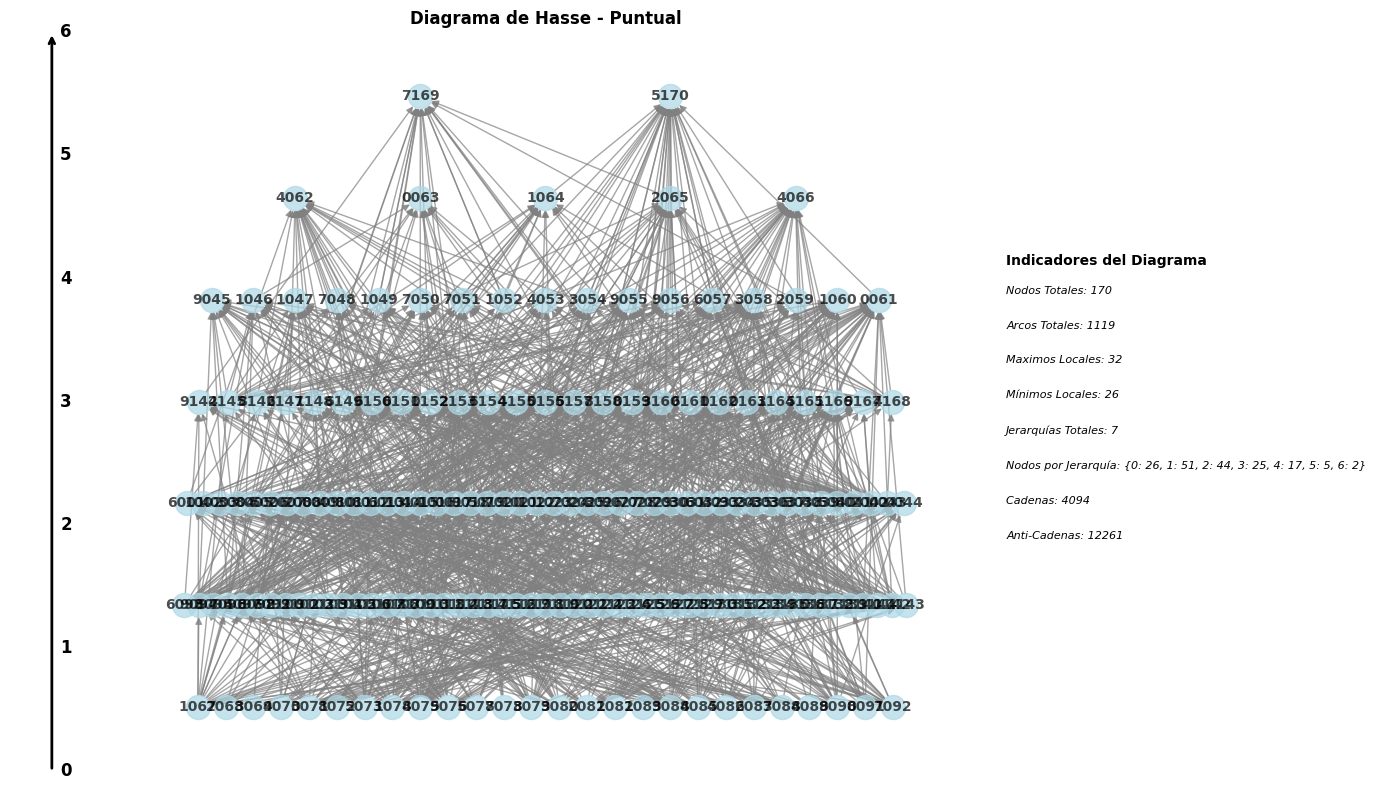

In [56]:
# paso 8: crear reporte para puntuales

# Crear la figura y el GridSpec
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(1, 12, figure=fig)  # Ajustamos GridSpec a 12 columnas

# Crear la subgráfica para el gráfico (ocupa 9/12 del espacio horizontal)
ax_graph = fig.add_subplot(gs[:, 1:10])

# Graficar el grafo
nx.draw(G_graph_arcs_reduced_relabeled_1_puntual, pos_1_puntual_pos_2, with_labels=True, ax=ax_graph,
        node_color='lightblue', node_size=300, font_size=10,
        font_color='black', font_weight='bold', edge_color='gray',
        width=1, alpha=0.7)

ax_graph.set_title("Diagrama de Hasse - Puntual", fontweight='bold')  # Título en negrita

# Añadir la flecha de jerarquía
ax_arrow = fig.add_subplot(gs[:, :1])
ax_arrow.axis('off')

total_hierarchies = reporte_1['Total Hierarchies'].iloc[0]

# Añadir la flecha
ax_arrow.annotate('', xy=(0.5, 1), xytext=(0.5, 0),
                  arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# Añadir las etiquetas de las jerarquías
for i in range(total_hierarchies):
    ax_arrow.text(0.6, i/(total_hierarchies-1), f'{i}', ha='left', va='center', fontsize=12, fontweight='bold')

# Crear la subgráfica para los indicadores (ocupa 2/12 del espacio horizontal)
ax_resumen = fig.add_subplot(gs[:, 10:])
ax_resumen.axis('off')  # Desactivar los ejes

# Agregar los indicadores como texto con separación y alineación a la izquierda
texto_resumen = f"""
\n
Nodos Totales: {reporte_1['Total Nodes'].iloc[0]}
\n
Arcos Totales: {reporte_1['Total Edges'].iloc[0]}
\n
Maximos Locales: {reporte_1['Local Max Nodes'].iloc[0]}
\n
Mínimos Locales: {reporte_1['Local Min Nodes'].iloc[0]}
\n
Jerarquías Totales: {reporte_1['Total Hierarchies'].iloc[0]}
\n
Nodos por Jerarquía: {reporte_1['Nodes Per Hierarchy'].iloc[0]}
\n
Cadenas: {reporte_1['Total Chains'].iloc[0]}
\n
Anti-Cadenas: {reporte_1['Total Antichains'].iloc[0]}
"""

# Ajustar la alineación del texto y el formato
ax_resumen.text(0.05, 0.5, texto_resumen, ha='left', va='center', fontsize=8, style='italic')
ax_resumen.text(0.05, 0.70, "Indicadores del Diagrama", ha='left', va='top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [48]:
# generando el listado de selected_columns_2

selected_columns_2 = selected_columns
#selected_columns_2.append("LOPM")
#selected_columns_2.append("hierarchy_level")
selected_columns_2.append("country")
selected_columns_2.append("industry")
selected_columns_2.append("ISIN")



In [49]:
# generando reporte de df puntual y un print del mismo de los primeros 10
df_filtrado_1 = df_punctual[selected_columns_2]

merged_inner_1_puntual = pd.merge(left=df_filtrado_1,right=df_combined_v1_1_puntual, left_on='ISIN', right_on='label')
merged_inner_1_puntual = merged_inner_1_puntual.nlargest(len(merged_inner_1_puntual), 'LOPM')

merged_inner_1_puntual.to_csv('df_puntual_report.csv')
merged_inner_1_puntual.nlargest(10, 'LOPM')

,ROA,ROE,EnEmission,Soworkforce,Govmanagement,country,industry,ISIN,label,label_relabeled,local_max,global_max,local_min,global_min,hierarchy_level,num_successors,num_predecessors,num_incomparable,LOPM
144,0.187604,0.4708,96.139999,98.540001,98.019997,UNITED STATES,8,US5949181045,US5949181045,5170,1,0,0,0,6,110,111,59,169.473214
9,0.188164,0.3931,98.910004,99.209999,87.230003,SWITZERLAND,7,CH0012005267,CH0012005267,7169,1,0,0,0,6,98,99,71,169.290000
161,0.129081,0.5095,98.279999,97.639999,79.180000,UNITED STATES,4,US87612E1064,US87612E1064,4066,1,0,0,0,5,72,73,97,168.689189
127,0.142461,0.5920,96.889999,99.089996,75.309998,UNITED STATES,5,US4278661081,US4278661081,1060,1,0,0,0,4,63,64,106,168.369231
2,0.106071,0.2198,89.669998,98.480003,99.070000,AUSTRALIA,2,AU000000BHP4,AU000000BHP4,4062,1,0,0,0,5,61,62,108,168.285714
105,0.113714,0.2675,98.820000,92.860001,90.459999,UNITED STATES,8,US17275R1023,US17275R1023,3058,1,0,0,0,4,57,58,112,168.101695
16,0.050749,0.3469,98.190002,97.919998,93.750000,GERMANY,4,DE0007100000,DE0007100000,0063,1,0,0,0,5,47,48,122,167.510204
75,0.044814,0.2223,98.500000,98.480003,98.480003,JAPAN,8,JP3435000009,JP3435000009,9055,1,0,0,0,4,45,46,124,167.361702
26,0.074724,0.1274,98.910004,95.139999,95.980003,FINLAND,2,FI0009005987,FI0009005987,7048,1,0,0,0,4,40,41,129,166.928571
1,0.039842,0.1779,98.910004,93.830002,96.430000,AUSTRIA,1,AT0000743059,AT0000743059,9045,1,0,0,0,4,37,38,132,166.615385


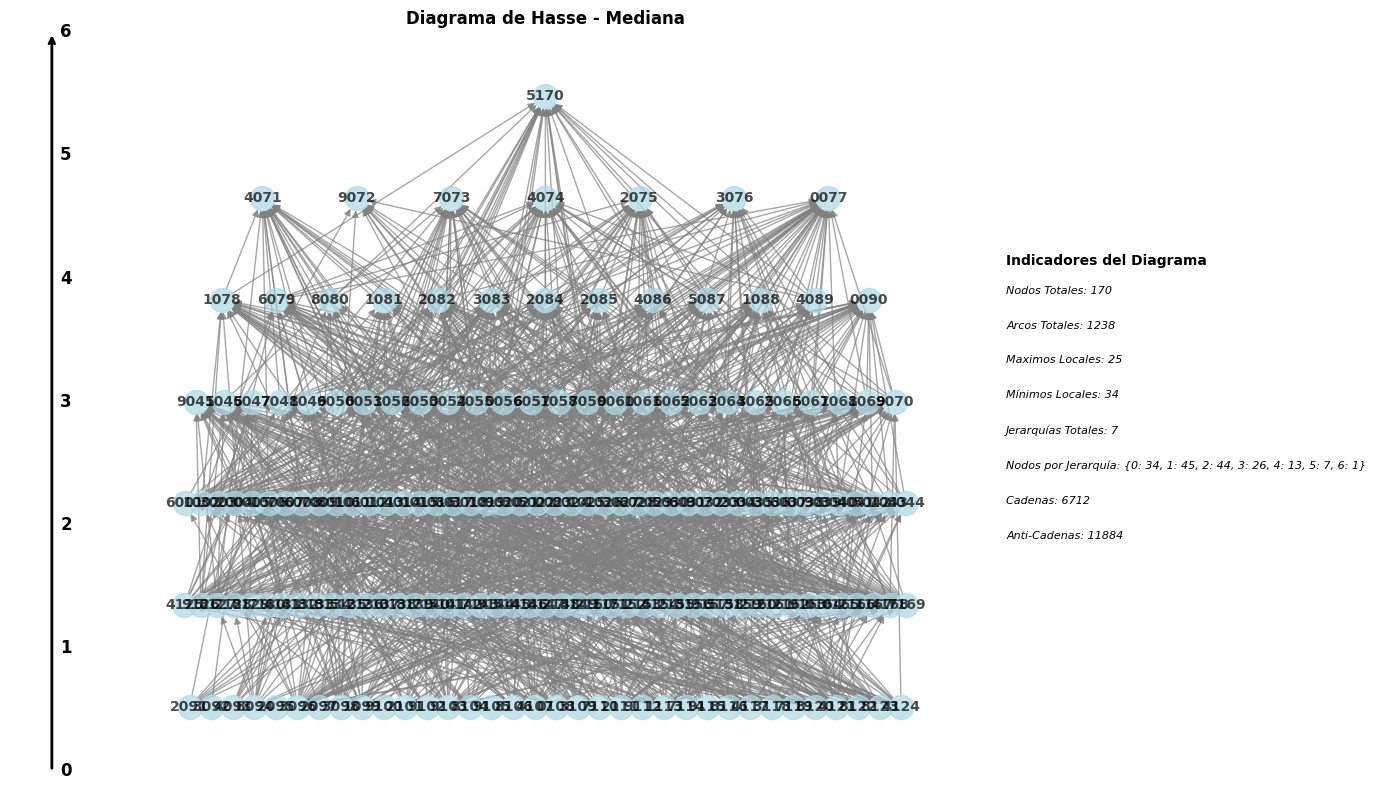

In [57]:
# paso 9: crear reporte para mediana

# Crear la figura y el GridSpec
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(1, 12, figure=fig)  # Ajustamos GridSpec a 12 columnas

# Crear la subgráfica para el gráfico (ocupa 9/12 del espacio horizontal)
ax_graph = fig.add_subplot(gs[:, 1:10])

# Graficar el grafo
nx.draw(G_graph_arcs_reduced_relabeled_2_mediana, pos_2_mediana_pos_2, with_labels=True, ax=ax_graph,
        node_color='lightblue', node_size=300, font_size=10,
        font_color='black', font_weight='bold', edge_color='gray',
        width=1, alpha=0.7)

ax_graph.set_title("Diagrama de Hasse - Mediana", fontweight='bold')  # Título en negrita

# Añadir la flecha de jerarquía
ax_arrow = fig.add_subplot(gs[:, :1])
ax_arrow.axis('off')

total_hierarchies = reporte_2['Total Hierarchies'].iloc[0]

# Añadir la flecha
ax_arrow.annotate('', xy=(0.5, 1), xytext=(0.5, 0),
                  arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# Añadir las etiquetas de las jerarquías
for i in range(total_hierarchies):
    ax_arrow.text(0.6, i/(total_hierarchies-1), f'{i}', ha='left', va='center', fontsize=12, fontweight='bold')

# Crear la subgráfica para los indicadores (ocupa 2/12 del espacio horizontal)
ax_resumen = fig.add_subplot(gs[:, 10:])
ax_resumen.axis('off')  # Desactivar los ejes

# Agregar los indicadores como texto con separación y alineación a la izquierda
texto_resumen = f"""
\n
Nodos Totales: {reporte_2['Total Nodes'].iloc[0]}
\n
Arcos Totales: {reporte_2['Total Edges'].iloc[0]}
\n
Maximos Locales: {reporte_2['Local Max Nodes'].iloc[0]}
\n
Mínimos Locales: {reporte_2['Local Min Nodes'].iloc[0]}
\n
Jerarquías Totales: {reporte_2['Total Hierarchies'].iloc[0]}
\n
Nodos por Jerarquía: {reporte_2['Nodes Per Hierarchy'].iloc[0]}
\n
Cadenas: {reporte_2['Total Chains'].iloc[0]}
\n
Anti-Cadenas: {reporte_2['Total Antichains'].iloc[0]}
"""

# Ajustar la alineación del texto y el formato
ax_resumen.text(0.05, 0.5, texto_resumen, ha='left', va='center', fontsize=8, style='italic')
ax_resumen.text(0.05, 0.70, "Indicadores del Diagrama", ha='left', va='top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [51]:
selected_columns = ["ROA","ROE","EnEmission","Soworkforce", "Govmanagement"]
selected_columns_2 = selected_columns
selected_columns_2.append("ISIN")

In [52]:
# generando reporte de df mediana y un print del mismo de los primeros 10

df_filtrado_2 = df_median[selected_columns_2]

merged_inner_2_mediana = pd.merge(left=df_filtrado_2,right=df_combined_v1_2_mediana, left_on='ISIN', right_on='label')
merged_inner_2_mediana = merged_inner_2_mediana.nlargest(len(merged_inner_2_mediana), 'LOPM')

merged_inner_2_mediana.to_csv('df_mediana_report.csv')
merged_inner_2_mediana.nlargest(10, 'LOPM')

,ROA,ROE,EnEmission,Soworkforce,Govmanagement,ISIN,label,label_relabeled,local_max,global_max,local_min,global_min,hierarchy_level,num_successors,num_predecessors,num_incomparable,LOPM
144,0.145675,0.28965,93.130001,94.965000,96.939999,US5949181045,US5949181045,5170,1,0,0,0,6,128,129,41,169.684615
162,0.179610,0.25555,94.294998,93.500000,87.994999,US8825081040,US8825081040,0077,1,0,0,0,5,120,121,49,169.598361
44,0.104091,0.33085,91.549999,98.195000,85.899998,GB0002875804,GB0002875804,4074,1,0,0,0,5,114,115,55,169.525862
2,0.091621,0.18695,91.239998,95.204998,98.024998,AU000000BHP4,AU000000BHP4,4071,1,0,0,0,5,90,91,79,169.141304
163,0.140175,0.33685,77.305000,93.750000,81.715000,US88579Y1010,US88579Y1010,0090,1,0,0,0,4,85,86,84,169.034483
9,0.093724,0.16400,95.014999,97.125000,93.340001,CH0012005267,CH0012005267,7073,1,0,0,0,5,80,81,89,168.914634
105,0.099869,0.17115,96.774998,91.890000,92.864998,US17275R1023,US17275R1023,3083,1,0,0,0,4,77,78,92,168.835443
151,0.095562,0.35485,66.766113,85.840000,96.415001,US7134481081,US7134481081,1088,1,0,0,0,4,62,63,107,168.328125
92,0.114419,0.48760,97.325001,80.790001,72.105004,US02209S1033,US02209S1033,3076,1,0,0,0,5,55,56,114,168.000000
29,0.064817,0.15905,95.975002,98.615002,76.330002,FR0000120271,FR0000120271,1081,1,0,0,0,4,48,49,121,167.580000


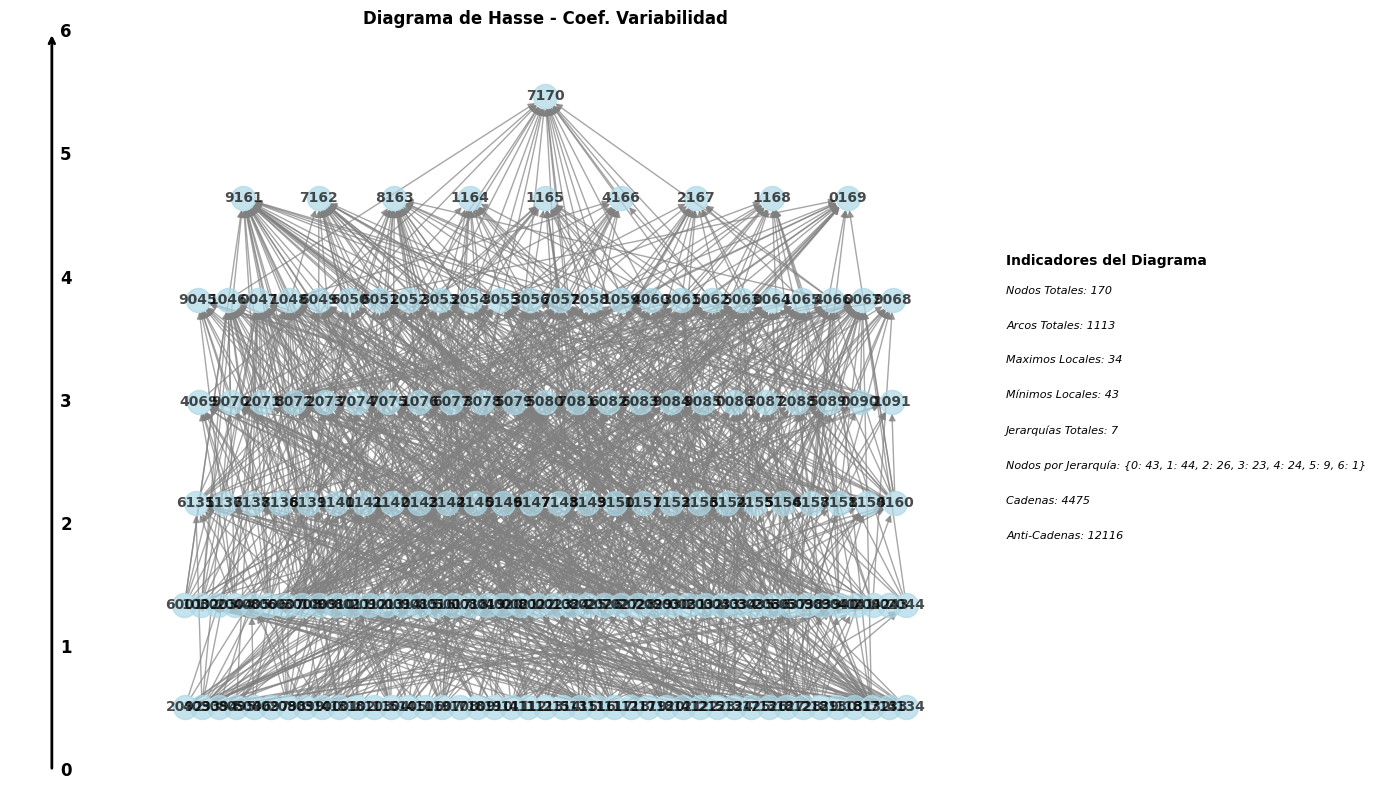

In [59]:
# paso 10: crear reporte para coeficiente de variabilidad

# Crear la figura y el GridSpec
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(1, 12, figure=fig)  # Ajustamos GridSpec a 12 columnas

# Crear la subgráfica para el gráfico (ocupa 9/12 del espacio horizontal)
ax_graph = fig.add_subplot(gs[:, 1:10])

# Graficar el grafo
nx.draw(G_graph_arcs_reduced_relabeled_3_variabilidad, pos_3_variabilidad_pos_2, with_labels=True, ax=ax_graph,
        node_color='lightblue', node_size=300, font_size=10,
        font_color='black', font_weight='bold', edge_color='gray',
        width=1, alpha=0.7)

ax_graph.set_title("Diagrama de Hasse - Coef. Variabilidad", fontweight='bold')  # Título en negrita

# Añadir la flecha de jerarquía
ax_arrow = fig.add_subplot(gs[:, :1])
ax_arrow.axis('off')

total_hierarchies = reporte_3['Total Hierarchies'].iloc[0]

# Añadir la flecha
ax_arrow.annotate('', xy=(0.5, 1), xytext=(0.5, 0),
                  arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# Añadir las etiquetas de las jerarquías
for i in range(total_hierarchies):
    ax_arrow.text(0.6, i/(total_hierarchies-1), f'{i}', ha='left', va='center', fontsize=12, fontweight='bold')

# Crear la subgráfica para los indicadores (ocupa 2/12 del espacio horizontal)
ax_resumen = fig.add_subplot(gs[:, 10:])
ax_resumen.axis('off')  # Desactivar los ejes

# Agregar los indicadores como texto con separación y alineación a la izquierda
texto_resumen = f"""
\n
Nodos Totales: {reporte_3['Total Nodes'].iloc[0]}
\n
Arcos Totales: {reporte_3['Total Edges'].iloc[0]}
\n
Maximos Locales: {reporte_3['Local Max Nodes'].iloc[0]}
\n
Mínimos Locales: {reporte_3['Local Min Nodes'].iloc[0]}
\n
Jerarquías Totales: {reporte_3['Total Hierarchies'].iloc[0]}
\n
Nodos por Jerarquía: {reporte_3['Nodes Per Hierarchy'].iloc[0]}
\n
Cadenas: {reporte_3['Total Chains'].iloc[0]}
\n
Anti-Cadenas: {reporte_3['Total Antichains'].iloc[0]}
"""

# Ajustar la alineación del texto y el formato
ax_resumen.text(0.05, 0.5, texto_resumen, ha='left', va='center', fontsize=8, style='italic')
ax_resumen.text(0.05, 0.70, "Indicadores del Diagrama", ha='left', va='top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [54]:
# generando reporte de df variabilidad y un print del mismo de los primeros 10

df_filtrado_3 = df_variability[selected_columns_2]

merged_inner_3_variabilidad = pd.merge(left=df_filtrado_3,right=df_combined_v1_3_variabilidad, left_on='ISIN', right_on='label')
merged_inner_3_variabilidad = merged_inner_3_variabilidad.nlargest(len(merged_inner_3_variabilidad), 'LOPM')

merged_inner_3_variabilidad.to_csv('df_variabilidad_report.csv')
merged_inner_3_variabilidad.nlargest(10, 'LOPM')

,ROA,ROE,EnEmission,Soworkforce,Govmanagement,ISIN,label,label_relabeled,local_max,global_max,local_min,global_min,hierarchy_level,num_successors,num_predecessors,num_incomparable,LOPM
34,0.419231,0.454805,0.028090,0.023656,0.223792,FR0000125007,FR0000125007,7170,1,0,0,0,6,86,87,83,169.056818
8,0.306825,0.331185,0.150867,0.088856,0.252981,CH0008742519,CH0008742519,9161,1,0,0,0,5,78,79,91,168.862500
30,0.298636,0.293921,0.148294,0.134648,0.289808,FR0000120321,FR0000120321,1165,1,0,0,0,5,68,69,101,168.557143
15,0.287472,0.319850,0.116957,0.095653,0.314381,DE0006048408,DE0006048408,8163,1,0,0,0,5,67,68,102,168.521739
136,0.302618,0.245692,0.124423,0.198694,0.205934,US50540R4092,US50540R4092,2167,1,0,0,0,5,64,65,105,168.409091
17,0.253748,0.283782,0.260700,0.135597,0.101067,DE0007236101,DE0007236101,1164,1,0,0,0,5,61,62,108,168.285714
151,0.302718,0.226117,0.207010,0.175155,0.057381,US7134481081,US7134481081,1168,1,0,0,0,5,60,61,109,168.241935
9,0.319299,0.374256,0.205001,0.153523,0.072809,CH0012005267,CH0012005267,7162,1,0,0,0,5,60,61,109,168.241935
162,0.480739,0.601412,0.141383,0.032964,0.215355,US8825081040,US8825081040,0169,1,0,0,0,5,57,58,112,168.101695
1,0.750817,0.726446,0.059906,0.047286,0.106413,AT0000743059,AT0000743059,9045,1,0,0,0,4,53,54,116,167.890909


In [ ]:
# generando reporte del dataset original
#df_punctual.to_csv('df_puntual_inicial.csv')
#df_median.to_csv('df_median_inicial.csv')
#df_variability.to_csv('df_variability_inicial.csv')


In [58]:
# notas: Excelente
# el grafo esta bien pero me esta colocando resultados diferentes en el dataframe final. En particular:
# los isin son los mismos que seleccione al principio
# LOPM es el mismo que el calculado en el ejemplo
# el ordenamiento es el mismo.